In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import gc
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "/media/fico/Data/Celeba/CelebAMask-HQ"

# Number of workers for dataloader
workers = 2

# Batch size during training



# Size of z latent vector (i.e. size of generator input)
nz = 512

# Size of feature maps in generator
ngf = 4


# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

lambda_gp = 10

d_ratio = 1

img_batch_size = [(4,16),(8,16),(16,16),(32,16),(64,16),(128,16)]



device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")



Random Seed:  999


In [3]:
data_loaders = []
for img_size, batch_size in img_batch_size:
    dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

    dataload = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=workers, drop_last=True)
    data_loaders.append(dataload)

x = next(iter(data_loaders[0]))
print(torch.min(x[0]), torch.max(x[0]))


tensor(-0.8980) tensor(0.8510)


In [37]:
# Generator Code
# Use upsample from latent or use dense layer to upsample?
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
#         self.added = nn.ModuleList([])
        self.up_samp = nn.Upsample(scale_factor = 2)
#         4
        self.block = nn.Sequential(
            nn.Upsample(scale_factor = 4),
            nn.Conv2d(nz, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end = nn.Conv2d(512, 3, 1, 1, 0)
        
#         8
        self.block1 = nn.Sequential(
            self.up_samp,
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end1 = nn.Conv2d(512, 3, 1, 1, 0)
        
#         16
        self.block2 = nn.Sequential(
            self.up_samp,
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end2 = nn.Conv2d(512, 3, 1, 1, 0)
        
#         32
        self.block3 = nn.Sequential(
            self.up_samp,
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end3 = nn.Conv2d(512, 3, 1, 1, 0)
        
#         64
        self.block4 = nn.Sequential(
            self.up_samp,
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end4 = nn.Conv2d(256, 3, 1, 1, 0)
        
#          128
        self.block5 = nn.Sequential(
            self.up_samp,
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(True),)
        self.end5 = nn.Conv2d(128, 3, 1, 1, 0)


#     Get this down to one if statement logic for fade in
    def forward(self, input, res, alpha):
        
        
        
        if res == 4:
            output = self.block(input)
            output = self.end(output)
        elif res == 8:
            output = self.block(input)
            if alpha >= 0:
                output_old = self.up_samp(output)
                output_old = self.end(output_old)
            output = self.block1(output)
            output = self.end1(output)
            if alpha >= 0:
                output = alpha*output + (1-alpha)*output_old
        elif res == 16:
            output = self.block(input)
            output = self.block1(output)
            if alpha >= 0:
                output_old = self.up_samp(output)
                output_old = self.end1(output_old)
            output = self.block2(output)
            output = self.end2(output)
            if alpha >= 0:
                output = alpha*output + (1-alpha)*output_old
        elif res == 32:
            output = self.block(input)
            output = self.block1(output)
            output = self.block2(output)
            if alpha >= 0:
                output_old = self.up_samp(output)
                output_old = self.end2(output_old)
            output = self.block3(output)
            output = self.end3(output)
            if alpha >= 0:
                output = alpha*output + (1-alpha)*output_old
        elif res == 64:
            output = self.block(input)
            output = self.block1(output)
            output = self.block2(output)
            output = self.block3(output)
            if alpha >= 0:
                output_old = self.up_samp(output)
                output_old = self.end3(output_old)
            output = self.block4(output)
            output = self.end4(output)
            if alpha >= 0:
                output = alpha*output + (1-alpha)*output_old
        elif res == 128:
            output = self.block(input)
            output = self.block1(output)
            output = self.block2(output)
            output = self.block3(output)
            output = self.block4(output)
            if alpha >= 0:
                output_old = self.up_samp(output)
                output_old = self.end4(output_old)
            output = self.block5(output)
            output = self.end5(output)
            if alpha >= 0:
                output = alpha*output + (1-alpha)*output_old
            
#         print(output.shape) 
        return output


In [38]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
#         self.added = nn.ModuleList([])
        self.down_samp = nn.AvgPool2d(2)
    
#         4
        self.block = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 4, 1, 0),
            nn.Flatten(),
            nn.Linear(512, 1))
        self.start = nn.Conv2d(3, 512, 1, 1, 0)
        
#         8
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            self.down_samp,)
        self.start1 = nn.Conv2d(3, 512, 1, 1, 0)

#         16
        self.block2 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            self.down_samp,)
        self.start2 = nn.Conv2d(3, 512, 1, 1, 0)
        
#         32
        self.block3 = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            self.down_samp,)
        self.start3 = nn.Conv2d(3, 512, 1, 1, 0)
        
#         64
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(True),
            self.down_samp,)
        self.start4 = nn.Conv2d(3, 256, 1, 1, 0)
        
#         128
        self.block5= nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(True),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(True),
            self.down_samp,)
        self.start5 = nn.Conv2d(3, 128, 1, 1, 0)


    
    def forward(self, input, res, alpha):   
        
        if res == 4:
            output = self.start(input)
            output = self.block(output)
            
        elif res == 8:
            output = self.start1(input)
            output = self.block1(output)
            
            if alpha >= 0:
                output_old = self.down_samp(input)
                output_old = self.start(output_old)
                output = alpha*output + (1-alpha)*output_old
            
            output = self.block(output)
        
        elif res == 16:
            output = self.start2(input)
            output = self.block2(output)
            
            if alpha >= 0:
                output_old = self.down_samp(input)
                output_old = self.start1(output_old)
                output = alpha*output + (1-alpha)*output_old
                
            output = self.block1(output)
            output = self.block(output)
            
        elif res == 32:
            output = self.start3(input)
            output = self.block3(output)
            
            if alpha >= 0:
                output_old = self.down_samp(input)
                output_old = self.start2(output_old)
                output = alpha*output + (1-alpha)*output_old
            
            output = self.block2(output)
            output = self.block1(output)
            output = self.block(output)
            
        elif res == 64:
            output = self.start4(input)
            output = self.block4(output)
            
            if alpha >= 0:
                output_old = self.down_samp(input)
                output_old = self.start3(output_old)
                output = alpha*output + (1-alpha)*output_old
                
            output = self.block3(output)
            output = self.block2(output)
            output = self.block1(output)
            output = self.block(output)
            
        elif res == 128:
            output = self.start5(input)
            output = self.block5(output)
            
            if alpha >= 0:
                output_old = self.down_samp(input)
                output_old = self.start4(output_old)
                output = alpha*output + (1-alpha)*output_old
            
            output = self.block4(output)
            output = self.block3(output)
            output = self.block2(output)
            output = self.block1(output)
            output = self.block(output)
            
#         print(output.shape) 
        return output


In [39]:
netG = Generator(ngpu).to(device)
netD = Discriminator(ngpu).to(device)
# with torch.cuda.amp.autocast(): 
#     test = torch.randn(16, nz, 1, 1, device=device)
#     test1 = torch.randn(16, 3, 128, 128, device=device)
    
#     temp = netG(test, res = 8, alpha = 1)
#     print(temp.shape)
#     netD(temp, res = 8, alpha = 1)

In [54]:

def training():


    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0
    
    label = torch.tensor(1)

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    scalerD = torch.cuda.amp.GradScaler()
    scalerG = torch.cuda.amp.GradScaler()
    
    
    training = True
    current_data = 0
    res = 4
    fade_in = False
    
    while(training):
        steps = 2000
        loader = iter(data_loaders[current_data])
        count = 0
        
    
        while count < steps:
            try:
                img = loader.next()
            except StopIteration:
                loader = iter(data_loaders[current_data])
                img = loader.next()
            if fade_in:
                alpha = -1
               
            else:
                alpha = count/steps
                
            mini_batch = len(img[0])
    
            real_imgs = img[0].to(device)
        
            netD.zero_grad()
            
#             Discriminator loss on real images

            output_real = netD(real_imgs, alpha=alpha, res=res).squeeze()

            
#             Discriminator loss on fake images
            
            noise = torch.randn(mini_batch, nz, 1, 1, device=device)
            fake_imgs = netG(noise, res=res, alpha=alpha)
            output_fake = netD(fake_imgs.detach(), alpha=alpha, res=res).squeeze()
            

#             Gradient Penalty
            
            gp_alpha = torch.randn(mini_batch, 1, 1, 1, device = device)
            interp = gp_alpha * real_imgs + ((1-gp_alpha) * fake_imgs.detach())
            interp.requires_grad = True
            model_interp = netD(interp, alpha = alpha, res = res)
            grads = torch.autograd.grad(outputs=model_interp, inputs=interp,
                          grad_outputs=torch.ones(model_interp.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
            grads = torch.square(grads)
            grads = torch.sum(grads, dim = [1,2,3])
            grads = torch.sqrt(grads)
            grads = grads - 1
            grads = torch.square(grads)
            grad_pen = grads * lambda_gp
            
#             Extra small penalty

            penalty = torch.square(output_real)
            penalty = penalty * .001
        
#             Calculating entire loss and taking step
            
            loss_D = output_fake - output_real + grad_pen + penalty
            loss_D = loss_D.mean()
            
            loss_D.backward()
            
            optimizerD.step()
#             loss_D = loss_fake + loss_real + grad_pen
            
                
                
            netG.zero_grad()
            
#             Generator loss on created batch

            output = netD(fake_imgs, alpha=alpha, res=res).squeeze()
            loss_G = -torch.mean(output)
            loss_G.backward()    

            optimizerG.step()

            

                
            count += mini_batch
            if count %500 <= mini_batch:
                print("Res:", res, "Fade_in:", fade_in, "Iter:",count)
                print("W with GP:", loss_D.item(),  "Loss G:", loss_G.item())
#                 print("Loss real:", loss_real.item(), "Loss Fake:", loss_fake.item())
                print()
        
        
        if fade_in == False:
            fade_in = True
            current_data += 1
            res = res * 2
        else:
            fade_in = False

    
    
    
training()
    
    
    
    



torch.Size([16])
output_fake torch.Size([16])
output_real torch.Size([16])
grad_pen torch.Size([16])
penalty torch.Size([16])
Res: 4 Fade_in: False Iter: 16
W with GP: -59.21198654174805 Loss G: 184.03488159179688


NameError: name 'loss_real' is not defined

torch.Size([64, 3, 4, 4]) tensor(0.2948) tensor(0.5572)
torch.Size([64, 4, 4, 3]) tensor(0.2948) tensor(0.5572)


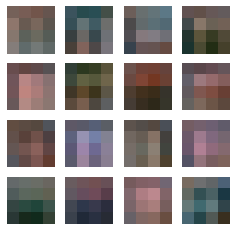

In [36]:

# OldRange = (OldMax - OldMin)  
# NewRange = (NewMax - NewMin)  
# NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin


fixed_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    guess = netG(fixed_noise, res = 4, alpha=1)
    guess = guess.cpu()
    old_min = torch.min(guess)
    old_max = torch.max(guess)
    old_range = old_max - old_min
    new_range = 1 - 0
    guess = (((guess - old_min)*new_range)/ old_range) + 0
#     guess = guess.float()
    print(guess.shape, torch.min(guess[0]), torch.max(guess[0]))
#     guess = ((guess *.5 ) + .5)
    guess = guess.permute(0,2,3,1)
    print(guess.shape, torch.min(guess[0]), torch.max(guess[0]))


    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(guess[i, :, :])
        plt.axis('off')
#     plt.savefig('end_train.png', dpi=300)
    plt.show()

In [ ]:
# First get it working without mixed precision  



# #             Discriminator loss on real images
#             with torch.cuda.amp.autocast(): 
#                 output_real = netD(real_imgs, alpha=alpha, res=res).squeeze()
#                 loss_real = -torch.mean(output_real)
# #                 print(loss_real)
# #             print(loss_real) 
#             scalerD.scale(loss_real).backward()
# #             print(loss_real)

            
#             noise = torch.randn(mini_batch, nz, 1, 1, device=device)
            
# #             Discriminator loss on fake images
#             with torch.cuda.amp.autocast():
            
#                 fake_imgs = netG(noise, res=res, alpha=alpha)
#                 output_fake = netD(fake_imgs.detach(), alpha=alpha, res=res).squeeze()
                
#                 loss_fake = torch.mean(output_fake)
            
#             scalerD.scale(loss_fake).backward()
            
# #             Gradient Penalty
#             with torch.cuda.amp.autocast():
#                 gp_alpha = torch.randn(mini_batch, 1, 1, 1, device = device)
#                 gp_alpha = gp_alpha.expand(real_imgs.size(0), real_imgs.size(1), real_imgs.size(2), real_imgs.size(3))
#                 interp = gp_alpha * real_imgs + ((1-gp_alpha) * fake_imgs.detach())
#                 interp.requires_grad = True
#                 model_interp = netD(interp, alpha = alpha, res = res)
            
#             grads = torch.autograd.grad(outputs=model_interp, inputs=interp,
#                               grad_outputs=torch.ones(model_interp.size()).to(device),
#                               create_graph=True, retain_graph=True, only_inputs=True)[0]
            
# #             Do I need to unscale the gradients for calculating gp for wasserstein?
# #             print(scaled_grad_params.shape)
# #             inv_scale = 1./scalerD.get_scale()
# #             grads = [p * inv_scale for p in scaled_grad_params]
# #             print(grads)
            
#             with torch.cuda.amp.autocast():
#                 grads = ((grads.norm(2, dim=1) - 1) ** 2).mean()
#                 grads += 1e-16
#                 grad_pen = grads * lambda_gp
# #                 print(grad_pen.item())
            
#             scalerD.scale(grad_pen).backward()
# #             print(grad_pen.item())
# #             return
#             scalerD.step(optimizerD)
#             scalerD.update()
#             loss_D = loss_fake + loss_real + grad_pen
            
                
                
#             netG.zero_grad()
            

#             with torch.cuda.amp.autocast():
#                 output = netD(fake_imgs, alpha=alpha, res=res).squeeze()
#                 loss_G = -torch.mean(output)
#             scalerG.scale(loss_G).backward()    

#             scalerG.step(optimizerG)
#             scalerG.update()
                
            
    